# Techno
Techno is a strategy based purely on technical indicators. The work is originated by Leon and reproduced by Jiawei.

In [8]:
from functools import reduce
import numpy as np
import pandas as pd
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import plot_roc_curve
from sklearn.metrics import make_scorer
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from xgboost import XGBClassifier
from xgboost import XGBRegressor
import matplotlib.pyplot as plt
import seaborn as sns
pd.set_option("display.max_rows", None)
pd.set_option("display.max_columns", None)
pd.options.mode.chained_assignment = None
np.seterr(divide="ignore", invalid="ignore")
import warnings
warnings.filterwarnings("ignore")

In [9]:
def compute_rsi(data, window):
    diff = data.diff(1)
    up_chg = 0 * diff
    down_chg = 0 * diff
    up_chg[diff > 0] = diff[diff > 0]
    down_chg[diff < 0] = diff[diff < 0]
    up_chg_avg = up_chg.ewm(com=window - 1, min_periods=window).mean()
    down_chg_avg = down_chg.ewm(com=window - 1, min_periods=window).mean()
    rs = abs(up_chg_avg / down_chg_avg)
    rsi = 1 - 1 / (1 + rs)
    return rsi

In [62]:
def build_techno(df):
    windows = [3, 4, 5, 10, 20, 40]
    df["pct_1m"] = df.close.groupby("gvkey").transform(lambda x: x.pct_change(1))
    for window in windows:
        df[f"std_{window}m"] = df.pct_1m.groupby("gvkey").transform(lambda x: x.rolling(window).std())
        df[f"sh_{window}m"] = df.pct_1m.groupby("gvkey").transform(lambda x: x.rolling(window).mean() / x.rolling(window).std())
        df[f"pct_{window}m"] = df.close.groupby("gvkey").transform(lambda x: x.pct_change(window - 1))
        df[f"ema_{window}m"] = df.close.groupby("gvkey").transform(lambda x: x / x.ewm(span=window, adjust=False).mean() -1 )
        df[f"qt_{window}m"] = df.close.groupby("gvkey").transform(lambda x: x.rolling(window).quantile(0.75) / x)
        df[f"scosc_{window}m"] = df.close.groupby("gvkey").transform(lambda x: (x - x.rolling(window).min()) / (x.rolling(window).max() - x.rolling(window).min()))
        df[f"rsi_{window}m"] = df.close.groupby("gvkey").transform(lambda x: compute_rsi(x, window))
    df['high'] = df['high'] / df['close'] - 1
    df['low'] = df['low'] / df['close'] - 1
    
    df_mom = df
    df_mom["targ_return"] = df_mom.close.groupby("gvkey").transform(lambda x: x.pct_change(3).shift(-3))

    df_mom["y1"] = np.where(df_mom['targ_return'] > 0.05, 1, 0)
    df_mom["y2"] = np.where(df_mom['targ_return'] < -0.03, -1, 0)
    df_mom["y"] = df_mom["y2"] + df_mom["y1"]
    
    df_mom = df_mom.drop('y2',axis=1)
    df_mom = df_mom.drop('y1',axis=1)
    df_mom = df_mom.drop('targ_return',axis=1)

    df = df_mom
    
    return df.loc[df.prccd>5, "high":].drop(columns=["volume", "close"]).dropna()

In [63]:
# select stocks with market cap > 100 million, trading price > 5 as stock universe
raw = pd.read_parquet("compustat_raw_alpha.1.parquet")
gvkeys = raw[(raw.mcap > 1e8) & (raw.prccd > 5)].index.get_level_values("gvkey").unique()
universe = raw.loc[gvkeys]

In [64]:
techno_features = build_techno(universe)

In [65]:
techno_features.head()
from pandas.tseries.offsets import DateOffset

In [66]:
# techno_features = build_techno(universe)
# features = discipline_features(techno_features)
X = techno_features.drop('y',axis=1)
y = techno_features.y

In [72]:
y.value_counts()

 1    49216
-1    43996
 0    38970
Name: y, dtype: int64

In [74]:
train_start="2002-01-01"
train_end="2010-01-01"
test_start=train_end
test_end="2016-01-01"
X_train = X.xs(slice(train_start, train_end), level="date", drop_level=False)
y_train = y.xs(slice(train_start, train_end), level="date", drop_level=False)
X_test = X.xs(slice(test_start, test_end), level="date", drop_level=False)
y_test = y.xs(slice(test_start, test_end), level="date", drop_level=False)

In [77]:
y_train.value_counts()

 1    24705
-1    22852
 0    17009
Name: y, dtype: int64

In [81]:
y_test.value_counts()

 1    24511
-1    21144
 0    21048
Name: y, dtype: int64

In [95]:
xgb_clf = XGBClassifier(max_depth=6, n_jobs=-1,class_weight='balanced')
xgb_fit = xgb_clf.fit(X_train, y_train)
y_pred= xgb_clf.predict(X_test)
# train_score = accuracy_score(y_train, xgb_clf.predict(X_train))
# test_score = accuracy_score(y_test, y_pred)
# feature_important = xgb_clf.get_booster().get_score(importance_type="gain")
# keys = list(feature_important.keys())
# values = list(feature_important.values())
# data = pd.DataFrame(data=values, index=keys, columns=["score"]).sort_values(by="score", ascending=False)
# data.plot(kind='barh')
# print(f"Accuracy on training set: {train_score}\nAccuracy on test set: {test_score}")
# print(classification_report(y_test, y_pred))

[17:37:21] WARNING: ../src/learner.cc:516: 
Parameters: { class_weight } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




In [96]:
def frame_to_signals(X, estimator):
    short_array = -1 * estimator.predict_proba(X)[:, 0]
    long_array = estimator.predict_proba(X)[:, -1]
    short_signal = pd.Series(short_array, X.index)
    long_signal = pd.Series(long_array, X.index)
    return short_signal, long_signal


def noise_to_belief(signal, n):
    return signal.groupby("date", group_keys=False).apply(
        lambda x: x.sort_values(ascending=False).head(n)
    )


def monthly_to_daily(signal, months, weight):
    daily_signals = []
    for index, value in signal.iteritems():
        gvkey = index[0]
        predict_date = pd.to_datetime(index[1])
        start = predict_date + DateOffset(days=1)
        end = predict_date + DateOffset(months=months)
        date_range = pd.date_range(start, end, freq="D", name="date")
        daily_idx = pd.MultiIndex.from_tuples(
            [(gvkey, date) for date in date_range], names=["gvkey", "date"]
        )
        if weight == "equal":
            daily_signal = pd.Series(np.sign(value), daily_idx)
        elif weight == "value":
            daily_signal = pd.Series(value, daily_idx)
        daily_signals.append(daily_signal)
    return pd.concat(daily_signals)


def signals_to_positions(short_signal, long_signal, n=30, months=3, weight="equal"):
    short_belief = noise_to_belief(short_signal, n)
    long_belief = noise_to_belief(long_signal, n)
    short_daily = monthly_to_daily(short_belief, months, weight)
    long_daily = monthly_to_daily(long_belief, months, weight)
    short_position = short_daily.groupby(["gvkey", "date"]).agg("sum")
    long_position = long_daily.groupby(["gvkey", "date"]).agg("sum")
    neutral_position = (
        pd.concat([short_position, long_position]).groupby(["gvkey", "date"]).agg("sum")
    )
    return short_position, long_position, neutral_position


def position_to_margin(data, position, tx=-0.001, method="log"):
    merged = pd.merge(
        position.rename("position"),
        data.close,
        how="left",
        left_index=True,
        right_index=True,
    )
    merged["close"] = merged.close.groupby("gvkey").fillna(method="ffill")
    merged["tx"] = np.where(position.shift(1) != position, tx, 0)
    if method == "log":
        merged["margin"] = (
            merged.close.groupby("gvkey")
            .transform(lambda x: np.log(x / x.shift(1)))
            .fillna(0)
        )
        margin = merged.position * merged.margin + merged.tx
        margin = margin.droplevel("gvkey").resample("D").mean().cumsum()
    elif method == "percent":
        merged["margin"] = (
            merged.close.groupby("gvkey").transform(lambda x: x.pct_change(1)).fillna(0)
        )
        margin = merged.position * merged.margin + merged.tx
        margin = 1 + margin.droplevel("gvkey").resample("D").mean().cumsum()
    return margin


def sharpe_ratio(data, position):
    merged = pd.merge(
        position.rename("position"),
        data.close,
        how="left",
        left_index=True,
        right_index=True,
    )
    merged["close"] = merged.close.groupby("gvkey").fillna(method="ffill")
    merged["tx"] = np.where(position.shift(1) != position, -0.001, 0)
    merged["margin"] = (
        merged.close.groupby("gvkey").transform(lambda x: x.pct_change(1)).fillna(0)
    )
    margin = merged.position * merged.margin + merged.tx
    margin = margin.droplevel("gvkey").resample("D").mean()
    return margin.mean() / margin.std() * np.sqrt(252)

In [97]:
short_signal, long_signal = frame_to_signals(X_test, xgb_clf)
short_position, long_position, neutral_position = signals_to_positions(short_signal, long_signal, n=30, months=3, weight="equal")

Sharpe ratio: 0.8372768670091016


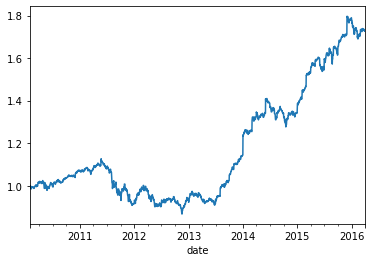

In [98]:
data = pd.read_parquet("daily_price_backtest.parquet")
data = data[data.index.get_level_values("gvkey") != '249103']
margin = position_to_margin(data, neutral_position, method="percent")
margin.plot()
sharpe = sharpe_ratio(data, neutral_position)
print(f"Sharpe ratio: {sharpe}")

Sharpe ratio: 1.6331827031592279


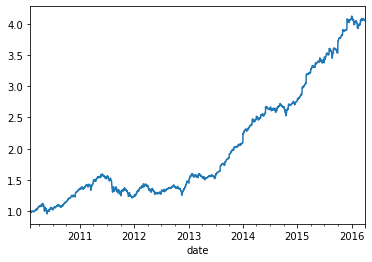

In [99]:
margin = position_to_margin(data, long_position, method="percent")
margin.plot()
sharpe = sharpe_ratio(data, long_position)
print(f"Sharpe ratio: {sharpe}")

Sharpe ratio: -2.012823387683273


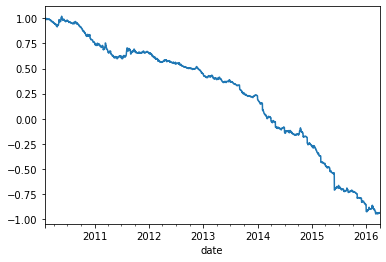

In [100]:
margin = position_to_margin(data, short_position, method="percent")
margin.plot()
sharpe = sharpe_ratio(data, short_position)
print(f"Sharpe ratio: {sharpe}")